## Download data  

In [ ]:
# !gdown --id 1bFx6uiQV-GUGwL3PwYRIYdmRCF9hS2bP

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Giải nén data

In [ ]:
!unzip -q "/content/drive/MyDrive/Data/FER-2013.zip"

## Load và xử lý data dạng ảnh

### Cách xử lý data dùng tf.data

#### Sử dụng Tensorflow để  build, compile và train và evaluate model. Kết quả train và evaluation được thể hiện bằng hình ảnh bằng cách sử dụng matplotlib

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize
from torchvision.io import read_image
import os
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)

In [ ]:
batch_size = 256
img_height = 180
img_width = 180
image_count = 28709
train_dir = "/content/train"
val_dir = "/content/test"

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, img_dir, norm):
        self.resize = Resize((img_height, img_width))
        self.norm = norm
        self.img_dir = img_dir
        self.classes = os.listdir(img_dir)
        self.image_files = [(os.path.join(cls, img), cls) for cls in self.classes for img in os.listdir(os.path.join(img_dir, cls))]
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.idx_to_class = {idx:cls  for cls, idx in self.class_to_idx.items()}

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path, cls = self.image_files[idx]
        image = self.resize(read_image(os.path.join(self.img_dir, img_path)))
        image = image.type(torch.float32)
        label = self.class_to_idx[cls]
        if self.norm:
            image = (image/127.5) - 1
        return image, label

In [ ]:
train_dataset = ImageDataset(train_dir, False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = ImageDataset(val_dir, False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


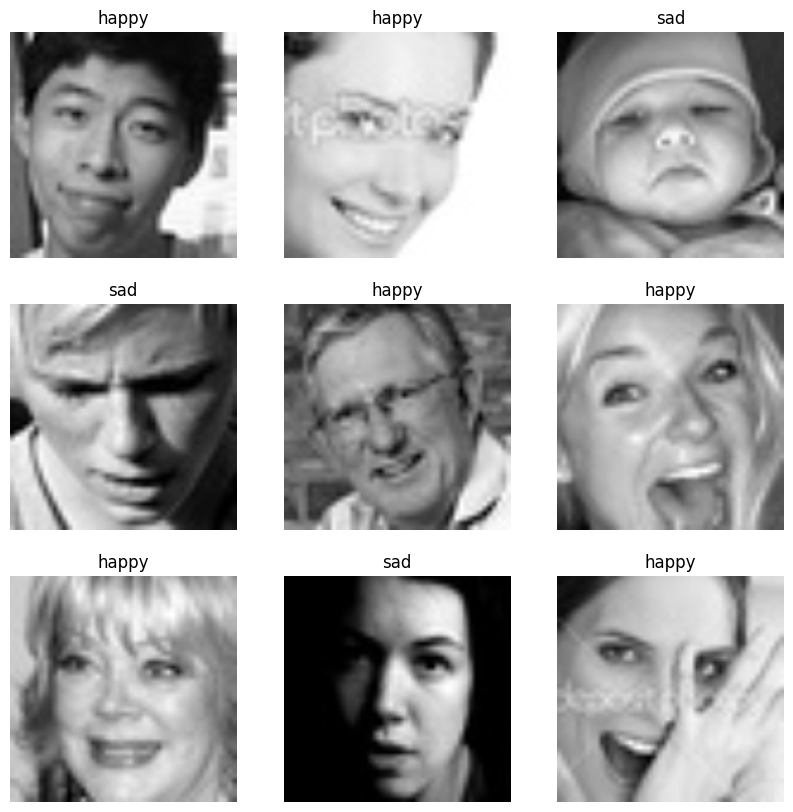

In [ ]:
image_batch, label_batch = next(iter(train_loader))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  minv = image_batch[i].numpy().min()
  maxv = image_batch[i].numpy().max()
  plt.imshow(np.squeeze(image_batch[i].numpy()), vmin=minv, vmax=maxv, cmap="gray")
  label = label_batch[i]
  plt.title(train_dataset.idx_to_class[label.item()])
  plt.axis("off")

##### Softmax Regression

In [ ]:
class SoftMaxRegression(nn.Module):
    def __init__(self, input_dims, num_classes):
        super(SoftMaxRegression, self).__init__()
        self.linear = nn.Linear(input_dims, num_classes)

    def forward(self, x):
        x = nn.Flatten()(x)
        out = self.linear(x)
        return out

model = SoftMaxRegression(input_dims=180*180, num_classes=7).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.006)

In [ ]:
num_epochs = 100
train_losses = []
train_acc = []
val_losses = []
val_acc = []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    accuracy = 0
    cnt = 0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        accuracy += (torch.argmax(outputs, 1) == y).sum().item()
        cnt += len(y)
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    accuracy /= cnt
    train_acc.append(accuracy)


    model.eval()
    val_loss = 0.0
    val_accuracy = 0
    cnt = 0
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = criterion(outputs, y)
            val_loss += loss.item()
            val_accuracy += (torch.argmax(outputs, 1) == y).sum().item()
            cnt += len(y)
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracy /= cnt
    val_acc.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train_Loss: {train_loss:.4f},  Train_Acc: {accuracy:.4f}, Val_Loss: {val_loss:.4f},  Val_Acc: {val_accuracy:.4f}")

Epoch 1/100, Train_Loss: 1214101.1733,  Train_Acc: 0.1772, Val_Loss: 1090063.8774,  Val_Acc: 0.1335
Epoch 2/100, Train_Loss: 1027848.6665,  Train_Acc: 0.1933, Val_Loss: 1080558.7365,  Val_Acc: 0.1740
Epoch 3/100, Train_Loss: 1045986.2887,  Train_Acc: 0.1977, Val_Loss: 854025.7888,  Val_Acc: 0.2803
Epoch 4/100, Train_Loss: 915036.0207,  Train_Acc: 0.2091, Val_Loss: 941790.1069,  Val_Acc: 0.1826
Epoch 5/100, Train_Loss: 890583.0473,  Train_Acc: 0.2166, Val_Loss: 873792.2198,  Val_Acc: 0.2760
Epoch 6/100, Train_Loss: 877690.2149,  Train_Acc: 0.2159, Val_Loss: 1075913.7174,  Val_Acc: 0.1726
Epoch 7/100, Train_Loss: 888033.5470,  Train_Acc: 0.2181, Val_Loss: 1231458.0418,  Val_Acc: 0.2611
Epoch 8/100, Train_Loss: 833967.2359,  Train_Acc: 0.2255, Val_Loss: 1228080.5057,  Val_Acc: 0.1351
Epoch 9/100, Train_Loss: 767739.2522,  Train_Acc: 0.2347, Val_Loss: 542528.0515,  Val_Acc: 0.3068
Epoch 10/100, Train_Loss: 830337.7456,  Train_Acc: 0.2263, Val_Loss: 835444.6122,  Val_Acc: 0.2770
Epoch 11/10

In [ ]:
train_loss

703465.6310840708

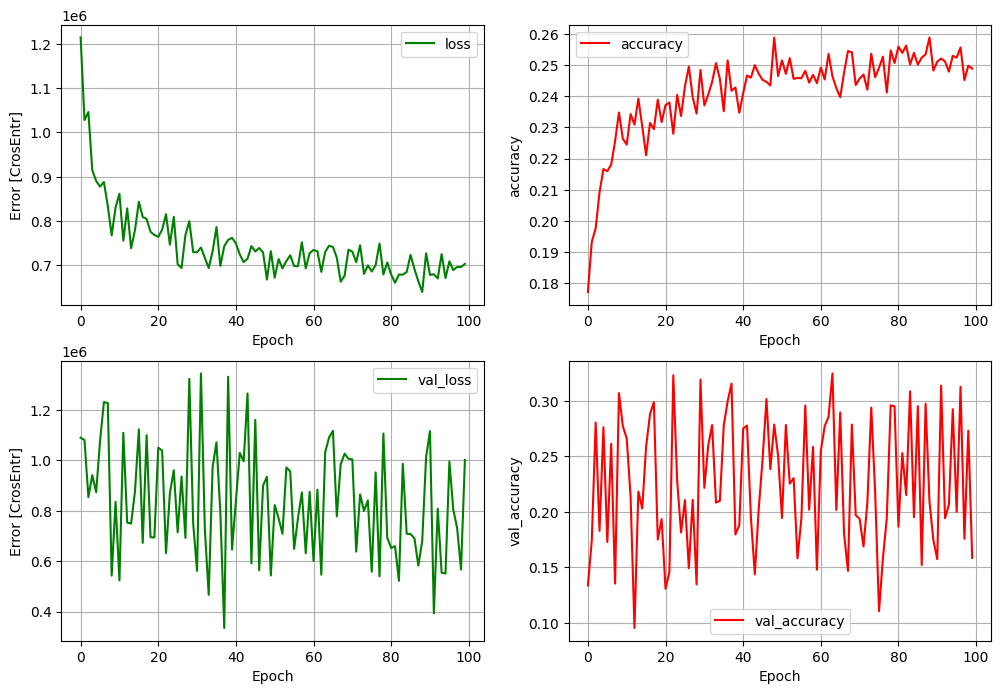

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Error [CrosEntr]')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(train_acc, label='accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(val_losses, label='val_loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Error [CrosEntr]')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(val_acc, label='val_accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('val_accuracy')
plt.legend()
plt.grid(True)
